# Exploring dense convolution

This notebook uses the fiber-tree emulator to display the behaviour of various 1-D convolutions for dense data. Because the data is assumed to be dense we use the position-based operators on the premise that for dense data the position and coordinate are the same.

First, include some libraries

In [1]:
# Begin - startup boilerplate code

import pkgutil

if 'fibertree_bootstrap' not in [pkg.name for pkg in pkgutil.iter_modules()]:
  !python3 -m pip  install git+https://github.com/Fibertree-project/fibertree-bootstrap --quiet

# End - startup boilerplate code


from fibertree_bootstrap import *
fibertree_bootstrap(style="uncompressed", animation="movie")

interactive(children=(Dropdown(description='style', options=('tree', 'uncompressed', 'tree+uncompressed'), val…

Button(description='Run all cells below', style=ButtonStyle())

## Convolution Inputs Selection

Using sliders to select the shapes of the weights and input activations

In [2]:
# Initial values

S = 3
W = 8
Q = W-S+1

density = [1.0]
seed = 10

enable_log = False

def set_params(rank_S, rank_W, rand_seed, log):
    global S
    global W
    global Q
    global density
    global seed
    global enable_log
    
    S = rank_S
    W = rank_W
    Q = W-S+1
    
    seed = rand_seed

    enable_log = (log == 'enable')

def log(*args):
    if enable_log:
        print(*args)

controls = interactive(set_params,
                       rank_S=widgets.IntSlider(min=2, max=9, step=1, value=S),
                       rank_W=widgets.IntSlider(min=2, max=12, step=1, value=W),
                       rand_seed=widgets.IntSlider(min=0, max=100, step=1, value=seed),
                       log=['disable', 'enable'])


display(controls)

interactive(children=(IntSlider(value=3, description='rank_S', max=9, min=2), IntSlider(value=8, description='…

## Create Input Tensors

Given shapes selected above create and display the filter weights (**f**) and input activations (**i**) and a reference output (**o_verify**)

Input activations


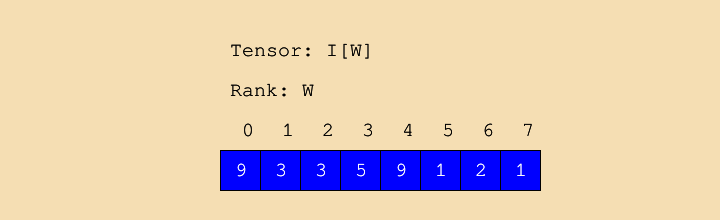

Filter Weights


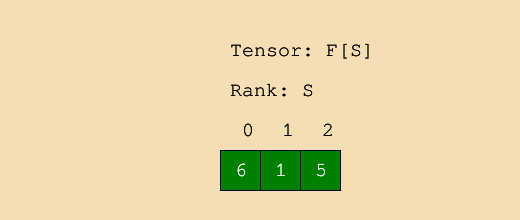

Output activations (expected)


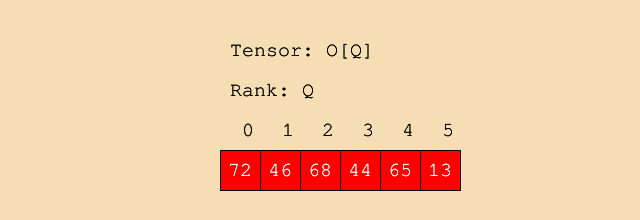

In [3]:
i_raw = [random.randint(1, 9) for i in range(W)]
f_raw = [random.randint(1, 9) for i in range(S)]
o_verify_raw = [0 for i in range(Q)]

for q in range(Q):
    for s in range(S):
        w = q+s
        o_verify_raw[q] += i_raw[w] * f_raw[s]

i = Tensor.fromUncompressed(["W"], i_raw)
f = Tensor.fromUncompressed(["S"], f_raw)
o_verify = Tensor.fromUncompressed(["Q"], o_verify_raw)

i.setName("I").setColor("blue")
f.setName("F").setColor("green")
o_verify.setName("O")

print("Input activations")
displayTensor(i)
print("Filter Weights")
displayTensor(f)
print("Output activations (expected)")
displayTensor(o_verify)


## Output Stationary

$$ O_{q} = I_{q+s} \times F_s $$

Convolution


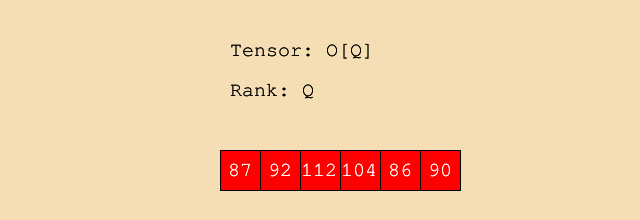

  0%|          | 0/20 [00:00<?, ?it/s]

In [4]:
o = Tensor(rank_ids=["Q"]).setName("O")

# Hack to fill in all the entries in o
o_q = o.getRoot()
o_q << Fiber(coords=range(Q), initial=1)

print("Convolution")

output_shape = Fiber(coords=range(Q), initial=1)

canvas = createCanvas(f, i, o)

for q in range(Q):
    log(f"Processing output: ({q}, ({o[q]}))")
    for w in range(W):
        s = w - q
        if s < 0 or s >= S: continue
        log(f"Processing input: ({w}, {i[w]})")
        log(f"  Processing filter weight ({s}, {f[s]})")
        o[q] += f[s] * i[w]

        canvas.addActivity((), [(w,) for w in range(q, q+S)], (), worker="W")
        canvas.addFrame((w-q,), (w,), (q,))

displayTensor(o)
displayCanvas(canvas)

assert o == o_verify

## Toplitz conversion

$$ T_{q,s} = I_{q+s} $$

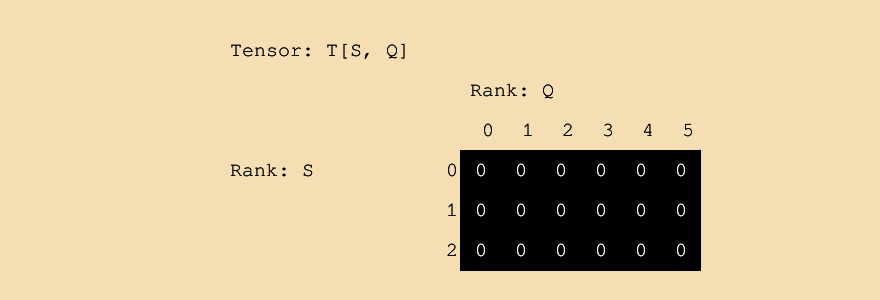

Toplitz matrix creation


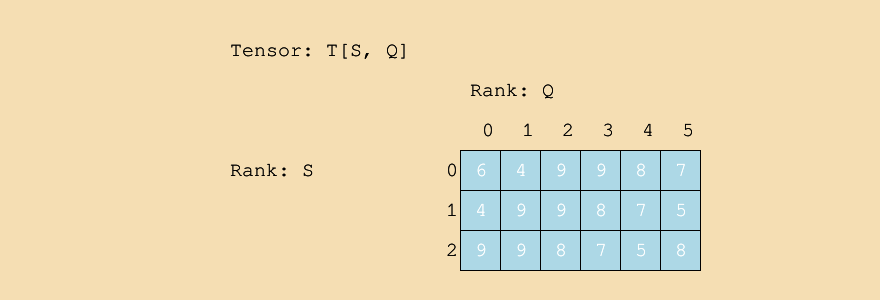

  0%|          | 0/20 [00:00<?, ?it/s]

In [5]:
t = Tensor(rank_ids=["S", "Q"], shape=[S, Q], name="T", color="lightblue")

t_s = t.getRoot()

# Hack to fill in all the entries in t
for s, t_q in t_s.iterShapeRef():
    for q, t_ref in t_q.iterShapeRef():
        pass
 
 
displayTensor(t)

print("Toplitz matrix creation")

canvas = createCanvas(i, t)

for q in range(Q):
    for s in range(S):
        t[s][q] <<= i[q+s]
        canvas.addFrame((q+s,), (s,q))

displayTensor(t)
displayCanvas(canvas)


## Convolution (using Toeplitz matrix)

$$ O_q = T_{q,s} \times F_s $$

Convolution


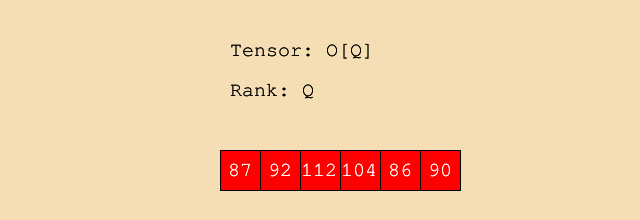

  0%|          | 0/20 [00:00<?, ?it/s]

In [6]:
o = Tensor(rank_ids=["Q"]).setName("O")

# Hack to fill in all the entries in o
o_q = o.getRoot()
o_q << Fiber(coords=range(Q), initial=1)

print("Convolution")

canvas = createCanvas(f, t, o)

for q in range(Q):
    for s in range(S):
        o[q] += f[s] * t[s,q]

        canvas.addActivity((), [(s,q) for s in range(S)], (), worker="W")
        canvas.addFrame((s,), (s,q), (q,))

displayTensor(o)
displayCanvas(canvas)

assert o == o_verify

## Testing area

For running alternative algorithms